In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import torch
import torchvision
import os
import pickle

In [212]:
data_train_packed = pickle.load(open("lego-train.pickle",'rb'))
data_test_packed = pickle.load(open("lego-test.pickle","rb"))

data_train = [torch.tensor(x).type(torch.float32).permute(2,0,1) for (x,y) in data_train_packed]
labels_train = [torch.tensor(y).type(torch.float32) for (x,y) in data_train_packed]

data_test = [torch.tensor(x).type(torch.float32).permute(2,0,1) for (x,y) in data_test_packed]
labels_test = [torch.tensor(y).type(torch.float32) for (x,y) in data_test_packed]

In [213]:
from datasets import ImageDataset

dataset_train = ImageDataset(data_train, torch.tensor(labels_train).reshape(-1,1))
dataset_test = ImageDataset(data_test, torch.tensor(labels_test).reshape(-1,1))

In [214]:
from models import CNN
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=1620, out_features=256, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (lin3): Linear(in_features=256, out_features=10, bias=True)
)


In [215]:
x = []
y = []

In [216]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()

def train_loop(epochs, dataloader:torch.utils.data.DataLoader):
    model.train()
    for epoch in range(epochs):
        ab_loss = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_function(logits, labels.type(torch.int64).reshape(-1))
            loss.backward()
            optimizer.step()
            ab_loss += loss
        x.append(ab_loss.item())
        y.append(epoch)
        if epoch % 100 == 0:
            print(ab_loss)
    model.eval()
    return(x,y)

In [217]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

train_loop(50, dataloader)
print()

tensor(43.8854, grad_fn=<AddBackward0>)


Text(0.5, 0, 'epoch')

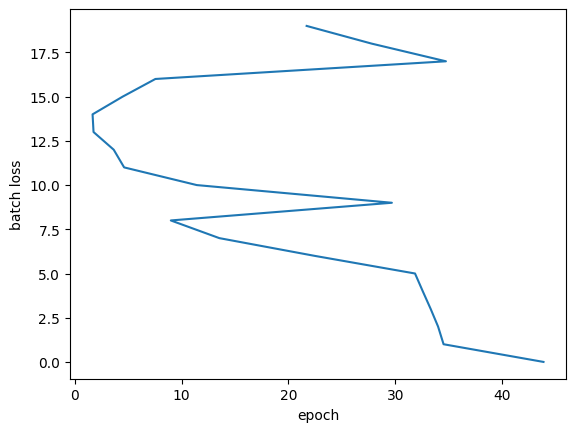

In [218]:
plt.plot(np.array(x),np.array(y))
plt.ylabel("batch loss")
plt.xlabel("epoch")

In [221]:
def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(6, 16, 5), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net

In [222]:
lenet = build_lenet()
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [223]:
def train(net, train_loader, num_epochs, learning_rate):
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0 
            
        for batch_num, (inputs, labels) in enumerate(train_loader):
            # Possibly copy inputs and labels to the GPU
            # batch x [48, 48, 1] -> batch x [1, 48, 48]          
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = loss_function(outputs, labels.type(torch.int64).reshape(-1))

            # Backpropagation                
            loss.backward()

            # Update
            optimizer.step()

            # Print progress
            running_loss += loss.item()

            # Calculate batch Accuracy
            _, predicted = outputs.max(1)
            batch_total = labels.size(0)
            batch_correct = predicted.eq(labels.type(torch.int64).reshape(-1)).sum().item()
            batch_acc = batch_correct/batch_total

            total += batch_total
            correct += batch_correct

        # Print the evaluation metric and reset it for the next epoch
        acc = correct/total 
        acc_history.append(acc)

    return acc_history

In [224]:
hist_lenet = train(lenet, dataloader, 100, 0.001)

In [225]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        labels = labels.type(torch.int64).reshape(-1)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the my model on the {total} test images: {100 * correct / total} %')

Accuracy of the network on the 150 test images: 58.666666666666664 %


In [226]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        labels = labels.type(torch.int64).reshape(-1)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the lenet on the {total} test images: {100 * correct / total} %')

Accuracy of the lenet on the 150 test images: 98.66666666666667 %
